## Part 2 - 2.1 and 2.2 together

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#rain1 event data
rain_data = pd.read_csv('data/rain1.csv')
rain_input = rain_data.iloc[:, 1].values  # Load rain input u
rain_output = rain_data.iloc[:, 2].values # Load rain output y

def run_simulation(a, sigma1_sq, sigma2_sq, rain_input):

    #simulation parameters
    np.random.seed(0)  #random seed for reproducibility
    
    C = np.vstack([0,0,0,1])
    B = np.hstack([1,0,0,0])


    #Transition matrix A
    A = np.array([[1-a, 0, 0, 0],
                [a, 1-a, 0, 0],
                [0, a, 1-a, 0],
                [0, 0, a, 0.98]])

    lik = np.zeros(len(rain_input)-1)

    def G(X): 
        ret= np.diag([
            np.sqrt(np.abs(X[0])),
            np.sqrt(np.abs(X[1])),
            np.sqrt(np.abs(X[2])),
            np.sqrt(np.abs(X[3])),
        ])
        return ret 

    Sigma1_sq = np.diag(
        [np.sqrt(sigma1_sq)] * 4  # In python we define variables based on SD not variance
    )

    X = np.zeros((len(rain_input), 4))  #State vector
    Y = np.zeros((len(rain_input), 1))  #Observation vector

    for i in range(1, len(rain_input)):
        X[i] = A @ X[i-1] + B.T * rain_input[i-1]  + np.diagonal(G(X[i-1]) @ np.random.normal(0, Sigma1_sq, (4,4)))
        Y[i] = C.T @ X[i].T + np.random.normal(0,np.sqrt(sigma2_sq)) # SD herenot variance because of python
        
        lik[i-1] = norm.pdf(rain_output[i], loc=Y[i], scale=np.sqrt(sigma2_sq))
    
    log_likelihood = np.log(lik[lik>0]).sum()
    
    return X, Y, log_likelihood

In [75]:
a = 0.02 # from 0.01 to 0.1
sigma1_sq = 0.01 # from 0.001 to 1
sigma2_sq = 0.2 # from 0.1 to 5

X, Y, log_likelihood = run_simulation(a, sigma1_sq, sigma2_sq)

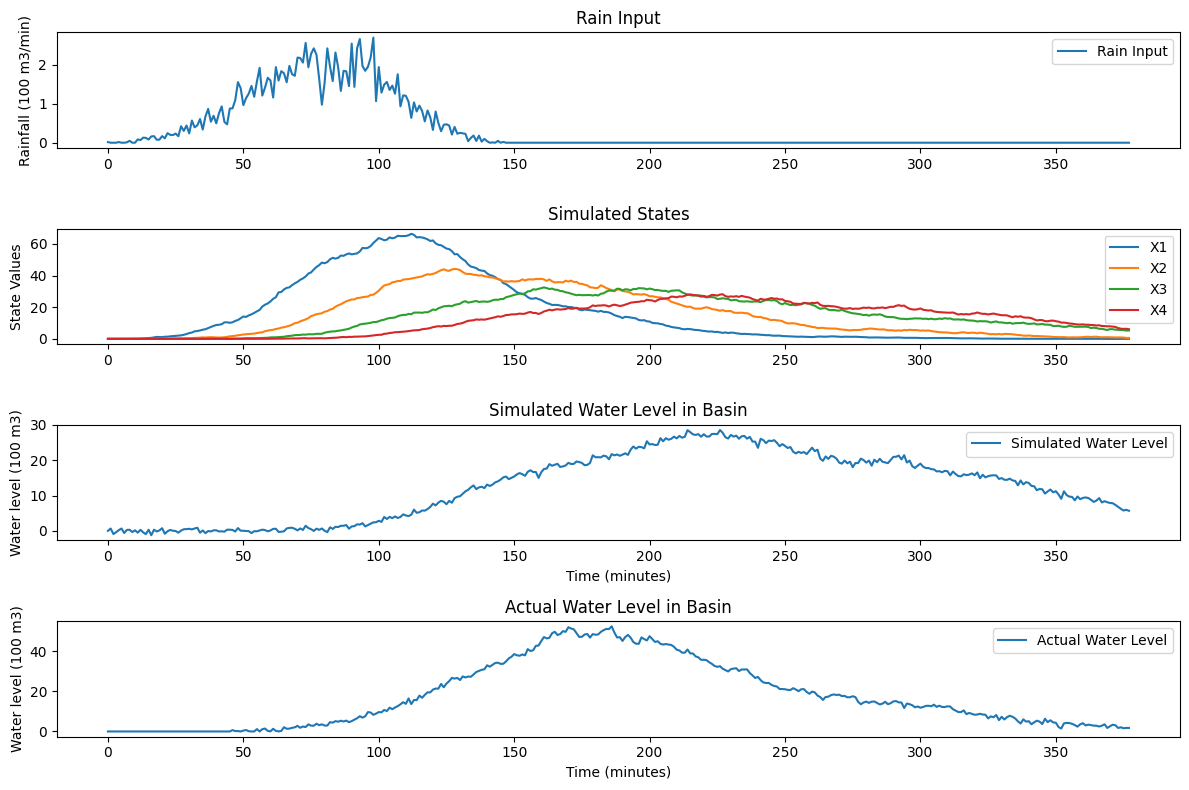

<Figure size 640x480 with 0 Axes>

In [67]:

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(rain_input, label='Rain Input')
plt.title("Rain Input")
plt.ylabel("Rainfall (100 m3/min)")
plt.legend()

plt.subplot(412)
plt.plot(X, label=['X1', 'X2', 'X3', 'X4'])
plt.title("Simulated States")
plt.ylabel("State Values")
plt.legend()

plt.subplot(413)
plt.plot(Y, label='Simulated Water Level')
plt.title("Simulated Water Level in Basin")
plt.xlabel("Time (minutes)")
plt.ylabel("Water level (100 m3)")
plt.legend()

plt.subplot(414)
plt.plot(rain_output, label='Actual Water Level')
plt.title("Actual Water Level in Basin")
plt.xlabel("Time (minutes)")
plt.ylabel("Water level (100 m3)")
plt.legend()

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

# Pt 3

In [ ]:

#rain1 event data
rain_data = pd.read_csv('data/rain1.csv')
rain_input = rain_data.iloc[:, 1].values  # Load rain input u
rain_output = rain_data.iloc[:, 2].values  # Load rain output y

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def run_simulation_log_likelihood(a, sigma1_sq, sigma2_sq, return_results=False):

    log_likelihoods = 0
    for i in range(1,5):
            
        rain_data = pd.read_csv(f'data/rain{i}.csv')
        rain_input = rain_data.iloc[:, 1].values  # Load rain input u
        rain_output = rain_data.iloc[:, 2].values # Load rain output y

        
        #simulation parameters
        np.random.seed(0)  #random seed for reproducibility
        
        C = np.vstack([0,0,0,1])
        B = np.hstack([1,0,0,0])


        #Transition matrix A
        A = np.array([[1-a, 0, 0, 0],
                    [a, 1-a, 0, 0],
                    [0, a, 1-a, 0],
                    [0, 0, a, 0.98]])

        lik = np.zeros(len(rain_input)-1)

        def G(X): 
            ret= np.diag([
                np.sqrt(np.abs(X[0])),
                np.sqrt(np.abs(X[1])),
                np.sqrt(np.abs(X[2])),
                np.sqrt(np.abs(X[3])),
            ])
            return ret 

        Sigma1_sq = np.diag(
            [np.sqrt(sigma1_sq)] * 4  # In python we define variables based on SD not variance
        )

        X = np.zeros((len(rain_input), 4))  #State vector
        Y = np.zeros((len(rain_input), 1))  #Observation vector

        for i in range(1, len(rain_input)):
            X[i] = A @ X[i-1] + B.T * rain_input[i-1]  + np.diagonal(G(X[i-1]) @ np.random.normal(0, Sigma1_sq, (4,4)))
            Y[i] = C.T @ X[i].T + np.random.normal(0,np.sqrt(sigma2_sq)) # SD herenot variance because of python
            
            lik[i-1] = norm.pdf(rain_output[i], loc=Y[i], scale=np.sqrt(sigma2_sq))
        
        log_likelihood = np.log(lik[lik>0]).sum()
        log_likelihoods += log_likelihood
    
    return log_likelihoods

In [159]:
from bayes_opt import BayesianOptimization

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"a": (0.01, 0.1), 
           "sigma1_sq": (0.001, 1), 
           "sigma2_sq": (0.1, 5)
        }

# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = run_simulation_log_likelihood,
                                 pbounds = pbounds, 
                                 verbose = 2,
                                 random_state = 4, 
                                 allow_duplicate_points=True)

optimizer.maximize(init_points = 100, n_iter = 700)

print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))


|   iter    |  target   |     a     | sigma1_sq | sigma2_sq |
-------------------------------------------------------------
| 1         | -7.604e+0 | 0.09703   | 0.5477    | 4.866     |
| 2         | -2.573e+0 | 0.07433   | 0.698     | 1.159     |
| 3         | -1.265e+0 | 0.09786   | 0.007224  | 1.34      |
| 4         | -2.809e+0 | 0.04913   | 0.7796    | 1.069     |
| 5         | -2.759e+0 | 0.08767   | 0.9834    | 0.9028    |
| 6         | -4.579e+0 | 0.06376   | 0.009977  | 1.994     |
| 7         | -2.079e+0 | 0.01397   | 0.9567    | 2.237     |
| 8         | -1.056e+0 | 0.09541   | 0.7865    | 4.345     |
| 9         | -2.775e+0 | 0.02558   | 0.07587   | 3.044     |
| 10        | -1.764e+0 | 0.02512   | 0.7336    | 2.101     |
| 11        | -1.93e+05 | 0.05751   | 0.9376    | 2.656     |
| 12        | -6.256e+0 | 0.01974   | 0.1591    | 2.771     |
| 13        | -1.924e+0 | 0.0572    | 0.638     | 2.067     |
| 14        | -8.816e+0 | 0.06848   | 0.3975    | 3.157     |
| 15    

In [161]:
rain_input = rain_data.iloc[:, 1].values  # Load rain input u
rain_output = rain_data.iloc[:, 2].values # Load rain output y

a = optimizer.max["params"]["a"]
sigma1_sq = optimizer.max["params"]["sigma1_sq"]
sigma2_sq = optimizer.max["params"]["sigma2_sq"]

X, Y, log_like= run_simulation(a, sigma1_sq, sigma2_sq, rain_input)

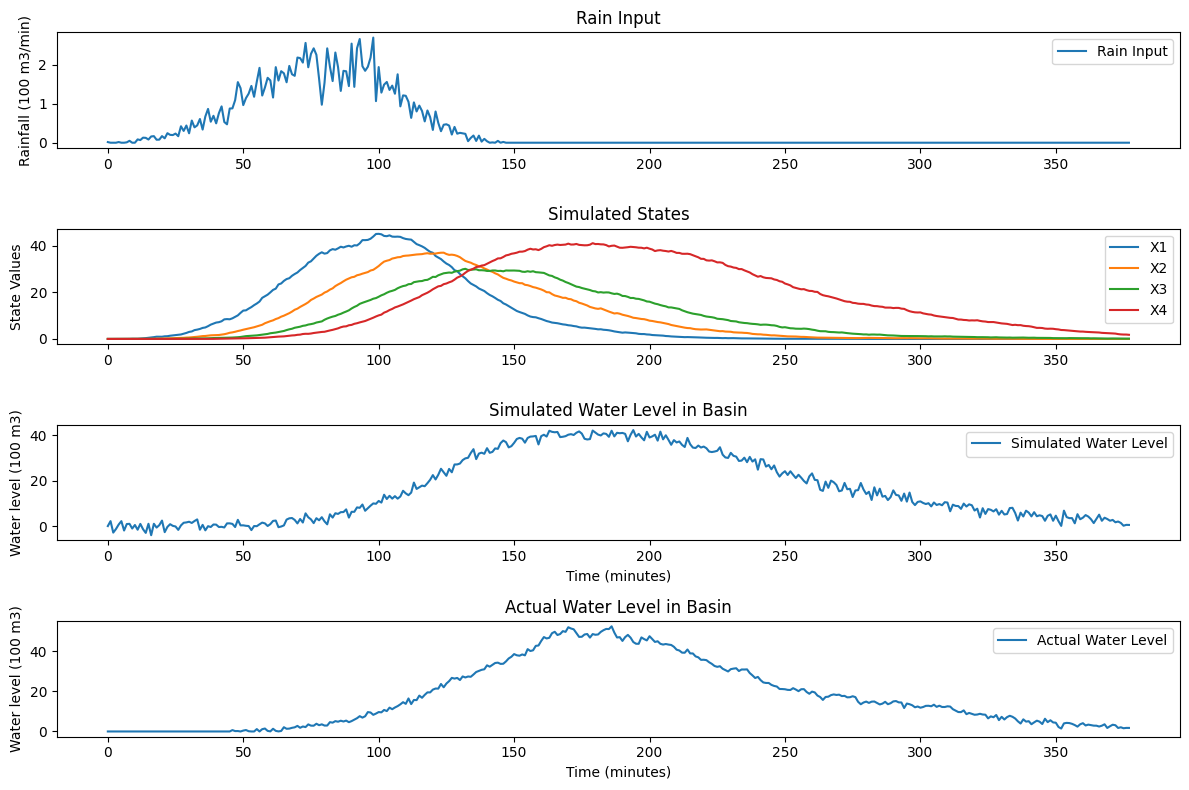

<Figure size 640x480 with 0 Axes>

In [162]:

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(rain_input, label='Rain Input')
plt.title("Rain Input")
plt.ylabel("Rainfall (100 m3/min)")
plt.legend()

plt.subplot(412)
plt.plot(X, label=['X1', 'X2', 'X3', 'X4'])
plt.title("Simulated States")
plt.ylabel("State Values")
plt.legend()

plt.subplot(413)
plt.plot(Y, label='Simulated Water Level')
plt.title("Simulated Water Level in Basin")
plt.xlabel("Time (minutes)")
plt.ylabel("Water level (100 m3)")
plt.legend()

plt.subplot(414)
plt.plot(rain_output, label='Actual Water Level')
plt.title("Actual Water Level in Basin")
plt.xlabel("Time (minutes)")
plt.ylabel("Water level (100 m3)")
plt.legend()

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [133]:
params = list(pd.DataFrame(optimizer.res)['params'])
target = list(pd.DataFrame(optimizer.res)['target'])


In [141]:
res = pd.concat([pd.DataFrame(params), pd.DataFrame(target, columns=['target'])], axis=1)

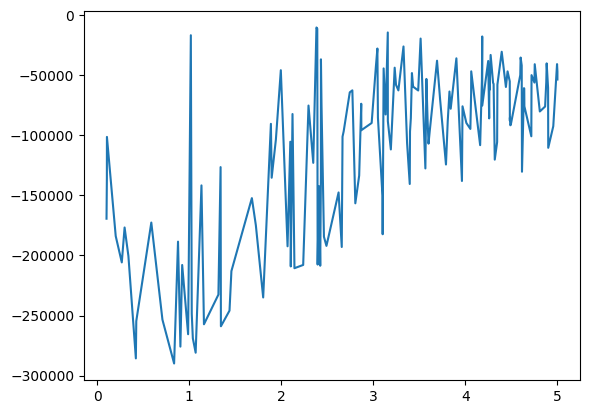

In [147]:
tmp = res.sort_values('sigma2_sq')
plt.plot(tmp['sigma2_sq'], tmp['target'], label='Actual Water Level')

In [152]:
result_df = pd.DataFrame()

for a in tqdm.tqdm(np.arange(0.01, 0.1, 0.01)):
    for sigma1_sq in tqdm.tqdm(np.arange(0.001, 1, 0.1)):
        for sigma2_sq in np.arange(0.1, 5, 0.1):
            X, Y, log_likelihood = run_simulation(a, sigma1_sq, sigma2_sq, rain_input)
            result_df = pd.concat([result_df,
                pd.DataFrame({'a': a, 'sigma1_sq': sigma1_sq, 'sigma2_sq': sigma2_sq, 'log_likelihood': log_likelihood}, index=[0])
            ])

100%|██████████| 9/9 [03:59<00:00, 26.63s/it]


In [154]:
result_df.groupby(['a']).log_likelihood.mean().to_frame().reset_index()

,a,log_likelihood
0,0.01,-38049.339527
1,0.02,-32199.205826
2,0.03,-27074.332330
3,0.04,-28986.438059
4,0.05,-33229.357104
5,0.06,-36418.516509
6,0.07,-38048.491941
7,0.08,-38255.717576
8,0.09,-39225.799989


<Figure size 1200x800 with 0 Axes>

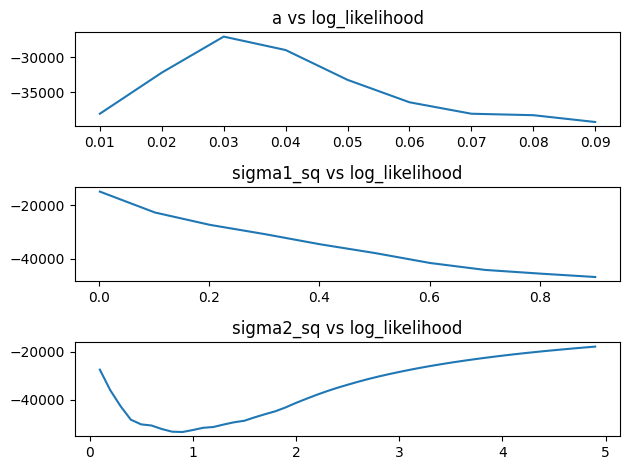

In [156]:
import matplotlib.pyplot as plt

# Group by 'a' and calculate mean
grouped_a = result_df.groupby(['a']).log_likelihood.mean()

# Group by 'sigma1_sq' and calculate mean
grouped_sigma1_sq = result_df.groupby(['sigma1_sq']).log_likelihood.mean()

# Group by 'sigma2_sq' and calculate mean
grouped_sigma2_sq = result_df.groupby(['sigma2_sq']).log_likelihood.mean()



plt.figure(figsize=(12, 8))

# Create subplots
fig, axs = plt.subplots(3)

# Plot 'a' vs 'log_likelihood'
axs[0].plot(grouped_a.index, grouped_a.values)
axs[0].set_title('a vs log_likelihood')

# Plot 'sigma1_sq' vs 'log_likelihood'
axs[1].plot(grouped_sigma1_sq.index, grouped_sigma1_sq.values)
axs[1].set_title('sigma1_sq vs log_likelihood')

# Plot 'sigma2_sq' vs 'log_likelihood'
axs[2].plot(grouped_sigma2_sq.index, grouped_sigma2_sq.values)
axs[2].set_title('sigma2_sq vs log_likelihood')

# Display the plot
plt.tight_layout()
plt.show()

In [160]:
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

Best result: {'a': 0.03703749935224916, 'sigma1_sq': 0.0020570452835744785, 'sigma2_sq': 2.1083771606122976}; f(x) = -6354.365433561673.


In [167]:
X, Y, log_like= run_simulation(a, sigma1_sq, sigma2_sq, rain_input)

In [168]:
log_like

-1481.2710385694959

In [169]:
X, Y, log_like= run_simulation(0.3, 0.001, 0.9, rain_input)

In [171]:
log_like

-53304.63014412618